In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import json
import os

from IPython.display import display

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
test_stat_files = [os.path.normpath(path) for path in glob("../data/models/*/test_stats.json")]
test_stat_files

['..\\data\\models\\all_multitask_shared\\test_stats.json',
 '..\\data\\models\\all_multitask_shared_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models\\all_multitask_shared_l2_0_lr_1e-3_no_neel\\test_stats.json',
 '..\\data\\models\\all_multitask_shared_ssa_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models\\all_multitask_shared_ssa_l2_0_lr_1e-3_no_neel\\test_stats.json',
 '..\\data\\models\\all_multitask_stacked\\test_stats.json',
 '..\\data\\models\\all_multitask_stacked_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models\\all_multitask_stacked_l2_0_lr_1e-3_no_neel\\test_stats.json',
 '..\\data\\models\\all_multitask_stacked_ssa_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models\\all_multitask_stacked_ssa_l2_0_lr_1e-3_no_neel\\test_stats.json',
 '..\\data\\models\\all_ner_bilstm\\test_stats.json',
 '..\\data\\models\\all_ner_bilstm_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models\\all_ner_bilstm_l2_0_lr_1e-3_no_neel\\test_stats.json',
 '..\\data\\models\\all_ner_ssa_l2_0_lr_1e-3\\t

In [4]:
test_stat_files[0].split(os.sep)[-3:-1]

['models', 'all_multitask_shared']

In [5]:
def parse_stats(stat, model):
    stats = []
    for task, task_stat in stat.items():
        task_suffix = task.rsplit("_")[-1]
        for file, file_stat in task_stat.items():
            file = os.path.normpath(file)
            if task_suffix in set(["ner", "chunk", "ccg"]):
                file_stat = {
                    k.rsplit("_")[-1]:v for k,v in file_stat.items()
                    if k.endswith(("f1-measure-overall", "precision-overall", "recall-overall"))
                }
            else:
                file_stat = {
                    k.rsplit("_")[-1]:v for k,v in file_stat.items()
                    if k.endswith("accuracy")
                }
            file_stat["file"] = "_".join(file.split(os.sep)[-3:-1])
            file_stat["task"] = task
            file_stat["task_type"] = task_suffix
            file_stat["model"] = model
            stats.append(file_stat)
    return stats

In [6]:
def parse_model_name(file):
    model = file.split(os.sep)[-2]
    model = model.replace("l2_0_lr_0.001", "*")
    model = model.replace("l2_0_lr_1e-3", "*")
    model = model.replace("no_neel_no_dimsum", "#") 
    model = model.replace("no_neel", "#") 
    model = model.replace("no_dimsum", "#")
    model = model.replace("self_attention", "sa")
    model = model.split("_")
    if model[0] != "all":
        model = ["S"] + model[2:]
    elif model[1] == "multitask":
        if model[2] == "stacked":
            model = ["MTL"]+model[3:]
        elif model[2] == "shared":
            model = ["MTS"]+model[3:]
    elif model[1] in {"ner", "pos"}:
        model = ["MD"]+model[2:]
    if len({"bilstm", "ssa"} & set(model)) == 0:
        model = model[:1] + ["bilstm"] + model[1:]
    # We cannot have different encoder for MTL stacked case, because of AllenNLP. It will be always biLSTM
    if model[1] == "ssa" and model[0] == "MTL":
        model[1] = "bilstm"
    model = " ".join(model)
    return model
 
def get_model_type(x):
    if x.startswith("S "): return "S"
    if x.startswith("MTL "): return "MTL"
    if x.startswith("MTS "): return "MTS"
    return "MD"
  
def get_model_params(x):
    if "*" in x: 
        if "#" in x:
            return "reg_no_neel"
        return "reg"
    if "#" in x:
        return "no_reg_no_neel"
    return "no_reg"


def get_layer_type(x):
    if "ssa" in x:
        return f"ssa"
    return f"bilstm"

In [7]:
stats = []
for file in test_stat_files:
    with open(file) as fp:
        stat = json.load(fp)
        model = parse_model_name(file)
        stats.extend(parse_stats(stat, model))
df = pd.DataFrame(stats).assign(
    model_type=lambda df_temp: pd.Categorical(
        df_temp["model"].map(get_model_type),
        categories=["S", "MD", "MTS", "MTL"],
        ordered=True
    ),
    is_regularized=lambda df_temp: df_temp["model"].str.contains("\*"),
    no_neel=lambda df_temp: df_temp["model"].str.contains("#"),
    regularized=lambda df_temp: df_temp["model"].map(get_model_params),
    layer_type=lambda df_temp: df_temp["model"].map(get_layer_type),
)
df.head()

,accuracy,f1-measure-overall,file,model,precision-overall,recall-overall,task,task_type,model_type,is_regularized,no_neel,regularized,layer_type
0,NaN,0.778723,NER_MSM2013,MTS bilstm,0.813333,0.746939,multimodal_ner,ner,MTS,False,False,no_reg,bilstm
1,NaN,0.674740,NER_MultiModal,MTS bilstm,0.756371,0.609012,multimodal_ner,ner,MTS,False,False,no_reg,bilstm
2,NaN,0.690715,NER_BROAD,MTS bilstm,0.738354,0.648851,broad_ner,ner,MTS,False,False,no_reg,bilstm
3,NaN,0.511255,NER_Finin,MTS bilstm,0.504725,0.517955,broad_ner,ner,MTS,False,False,no_reg,bilstm
4,NaN,0.870838,NER_Hege,MTS bilstm,0.945171,0.807344,broad_ner,ner,MTS,False,False,no_reg,bilstm


In [8]:
df.layer_type.value_counts()

bilstm    240
ssa        85
Name: layer_type, dtype: int64

In [9]:
TRUE_MODEL_ORDER = df.groupby("model").first().assign(
    model_type=lambda x: pd.Categorical(x["model_type"], categories=["S", "MD", "MTS", "MTL"], ordered=True)
).sort_values(["layer_type", "no_neel", "is_regularized", "model_type", ], ascending=[True, True, True, True]).index.values
TRUE_MODEL_ORDER

array(['S bilstm', 'MD bilstm', 'MTS bilstm', 'MTL bilstm', 'S bilstm *',
       'MD bilstm *', 'MTS bilstm *', 'MTL bilstm *', 'MD bilstm * #',
       'MTS bilstm * #', 'MTL bilstm * #', 'S ssa *', 'MD ssa *',
       'MTS ssa *', 'MD ssa * #', 'MTS ssa * #'], dtype=object)

In [10]:
def plot_measures(df, task="pos", measure="accuracy"):
    df_tt = df[(df.task_type == task) & (df.file != "NER_NEEL2016")][[
        measure, "file", "model", "model_type",
    ]].assign(
        # 2 task files can have same suffix so split here.
        file=lambda df_temp: df_temp["file"].str.split("_", 1, expand=True)[1], 
        **{
            measure: lambda df_temp: df_temp[measure]*100.
        }
    )
    df_t = df_tt.pivot_table(
        index="model",
        columns="file",
        values=measure,
        aggfunc="max"
    ).fillna(0)
    #df_t = df_t.assign(mean_value=df_t.mean(axis=1)).sort_values("mean_value", ascending=False).drop("mean_value", axis=1)
    sort_order = TRUE_MODEL_ORDER
    df_t = df_t.reindex(sort_order).dropna(axis=0)
    nmodels, ncols = df_t.shape
    display(df_t)
    nfig_cols = 3
    nrows = np.ceil(ncols/nfig_cols).astype(int)
    
    df_t_ranked = df_t.rank(ascending=False).astype(int)
    
    """
    df_t.plot(
        kind="barh", figsize=(20,(0.5*nmodels)*nrows), subplots=True, legend=False,
        sharex=False, color="0.5", layout=(nrows,nfig_cols), sharey=True
    )
    """
    y_col = "model"
    hue_col = "model_type"
    y_order = sort_order
    hue_order = df["model"].map(get_model_type).value_counts().index.values
    markers = ["o", "s", "*", "^", "v"][:hue_order.shape[0]]
    plot_height=np.max([4.0, 0.5*df_tt[y_col].value_counts().shape[0]])
    g = sns.FacetGrid(
        data=df_tt, 
        col="file", col_wrap=3,
        hue=hue_col, 
        hue_order=hue_order,
        height=plot_height, aspect=1,
        sharex=False,
        hue_kws=dict(marker=markers)
    )
    (g.map(sns.stripplot, measure, y_col, orient="h", size=20, order=y_order))
    #plt.tight_layout()
    
    
    df_t_merged = pd.concat([df_t_ranked, df_t], 
        keys=["r", "v"],
        axis=1
    ).reorder_levels([1, 0], axis=1).sort_index(axis=1)
    with pd.option_context("precision", 2):
        display(df_t_merged) 
        print(df_t_merged.to_latex(bold_rows=True, multicolumn_format='c'))
    
    fig = plt.figure(figsize=(10, 10))
    print(df_t.columns)
    sns.heatmap(
        df_t_ranked.T, 
        cmap="viridis_r", linewidths=.5, annot=True, fmt="d",
        square=True,
        cbar=False,
        cbar_kws = dict(use_gridspec=False,location="top")
    )
    
    display(pd.concat([df_t.idxmax(), df_t.max()], axis=1, keys=["model", "score"]))
    return df_t_merged

file,DiMSUM2016,Foster,Owoputi,Ritter,Tweetbankv2,TwitIE,lowlands
model,,,,,,,
S bilstm,85.296970,69.095389,89.457494,90.227412,91.568473,89.862724,66.520158
MD bilstm,85.218182,68.109820,89.373602,88.567916,92.050275,88.701162,66.353440
MTS bilstm,85.084848,68.673002,86.814877,79.102643,89.463210,79.655051,65.267253
MTL bilstm,84.709091,67.969025,86.563199,77.811924,89.499869,76.663147,65.403658
S bilstm *,85.727273,69.341781,90.883669,89.858636,92.270228,89.897923,67.005153
MD bilstm *,86.387879,68.743400,91.387025,91.456669,92.102645,90.355509,67.363848
MTS bilstm *,86.345455,69.165787,91.359060,91.395206,91.573710,91.622668,67.651814
MTL bilstm *,86.448485,69.306582,91.610738,91.702520,92.437811,91.270679,68.020612
MTS bilstm * #,86.769697,68.532207,91.401007,91.518132,92.343545,90.320310,67.889259


file           DiMSUM2016        Foster        Owoputi        Ritter         \
                        r      v      r      v       r      v      r      v   
model                                                                         
S bilstm               11  85.30      5  69.10      11  89.46      9  90.23   
MD bilstm              12  85.22     13  68.11      12  89.37     12  88.57   
MTS bilstm             13  85.08      9  68.67      13  86.81     13  79.10   
MTL bilstm             14  84.71     14  67.97      14  86.56     14  77.81   
S bilstm *              9  85.73      1  69.34       7  90.88     10  89.86   
MD bilstm *             4  86.39      7  68.74       4  91.39      4  91.46   
MTS bilstm *            5  86.35      4  69.17       5  91.36      5  91.40   
MTL bilstm *            2  86.45      2  69.31       2  91.61      2  91.70   
MTS bilstm * #          1  86.77     11  68.53       3  91.40      3  91.52   
MTL bilstm * #          3  86.39      5  69.10       1  91.76      1  92.01   
S ssa *                10  85.46      3  69.20      10  90.63     11  89.67   
MD ssa *                8  85.83     12  68.36       6  90.93      7  90.96   
MTS ssa *               6  86.02      8  68.71       9  90.72      6  91.15   
MTS ssa * #             7  85.98     10  68.64       7  90.88      8  90.35   

file           Tweetbankv2        TwitIE        lowlands         
                         r      v      r      v        r      v  
model                                                            
S bilstm                12  91.57     10  89.86       10  66.52  
MD bilstm               10  92.05     12  88.70       11  66.35  
MTS bilstm              14  89.46     13  79.66       14  65.27  
MTL bilstm              13  89.50     14  76.66       13  65.40  
S bilstm *               5  92.27      9  89.90        9  67.01  
MD bilstm *              9  92.10      7  90.36        5  67.36  
MTS bilstm *            11  91.57      1  91.62        4  67.65  
MTL bilstm *             1  92.44      2  91.27        2  68.02  
MTS bilstm * #           2  92.34      8  90.32        3  67.89  
MTL bilstm * #           4  92.31      6  90.50        1  68.10  
S ssa *                  6  92.24     11  89.55        7  67.10  
MD ssa *                 2  92.34      5  90.67        6  67.13  
MTS ssa *                7  92.23      3  90.85        8  67.07  
MTS ssa * #              8  92.16      4  90.74       12  66.30

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{DiMSUM2016} & \multicolumn{2}{c}{Foster} & \multicolumn{2}{c}{Owoputi} & \multicolumn{2}{c}{Ritter} & \multicolumn{2}{c}{Tweetbankv2} & \multicolumn{2}{c}{TwitIE} & \multicolumn{2}{c}{lowlands} \\
{} &          r &      v &      r &      v &       r &      v &      r &      v &           r &      v &      r &      v &        r &      v \\
\textbf{model         } &            &        &        &        &         &        &        &        &             &        &        &        &          &        \\
\midrule
\textbf{S bilstm      } &         11 &  85.30 &      5 &  69.10 &      11 &  89.46 &      9 &  90.23 &          12 &  91.57 &     10 &  89.86 &       10 &  66.52 \\
\textbf{MD bilstm     } &         12 &  85.22 &     13 &  68.11 &      12 &  89.37 &     12 &  88.57 &          10 &  92.05 &     12 &  88.70 &       11 &  66.35 \\
\textbf{MTS bilstm    } &         13 &  85.08 &      9 &  68.67 &      13 &  8

,model,score
file,,
DiMSUM2016,MTS bilstm * #,86.769697
Foster,S bilstm *,69.341781
Owoputi,MTL bilstm * #,91.764541
Ritter,MTL bilstm * #,92.009834
Tweetbankv2,MTL bilstm *,92.437811
TwitIE,MTS bilstm *,91.622668
lowlands,MTL bilstm * #,68.096393


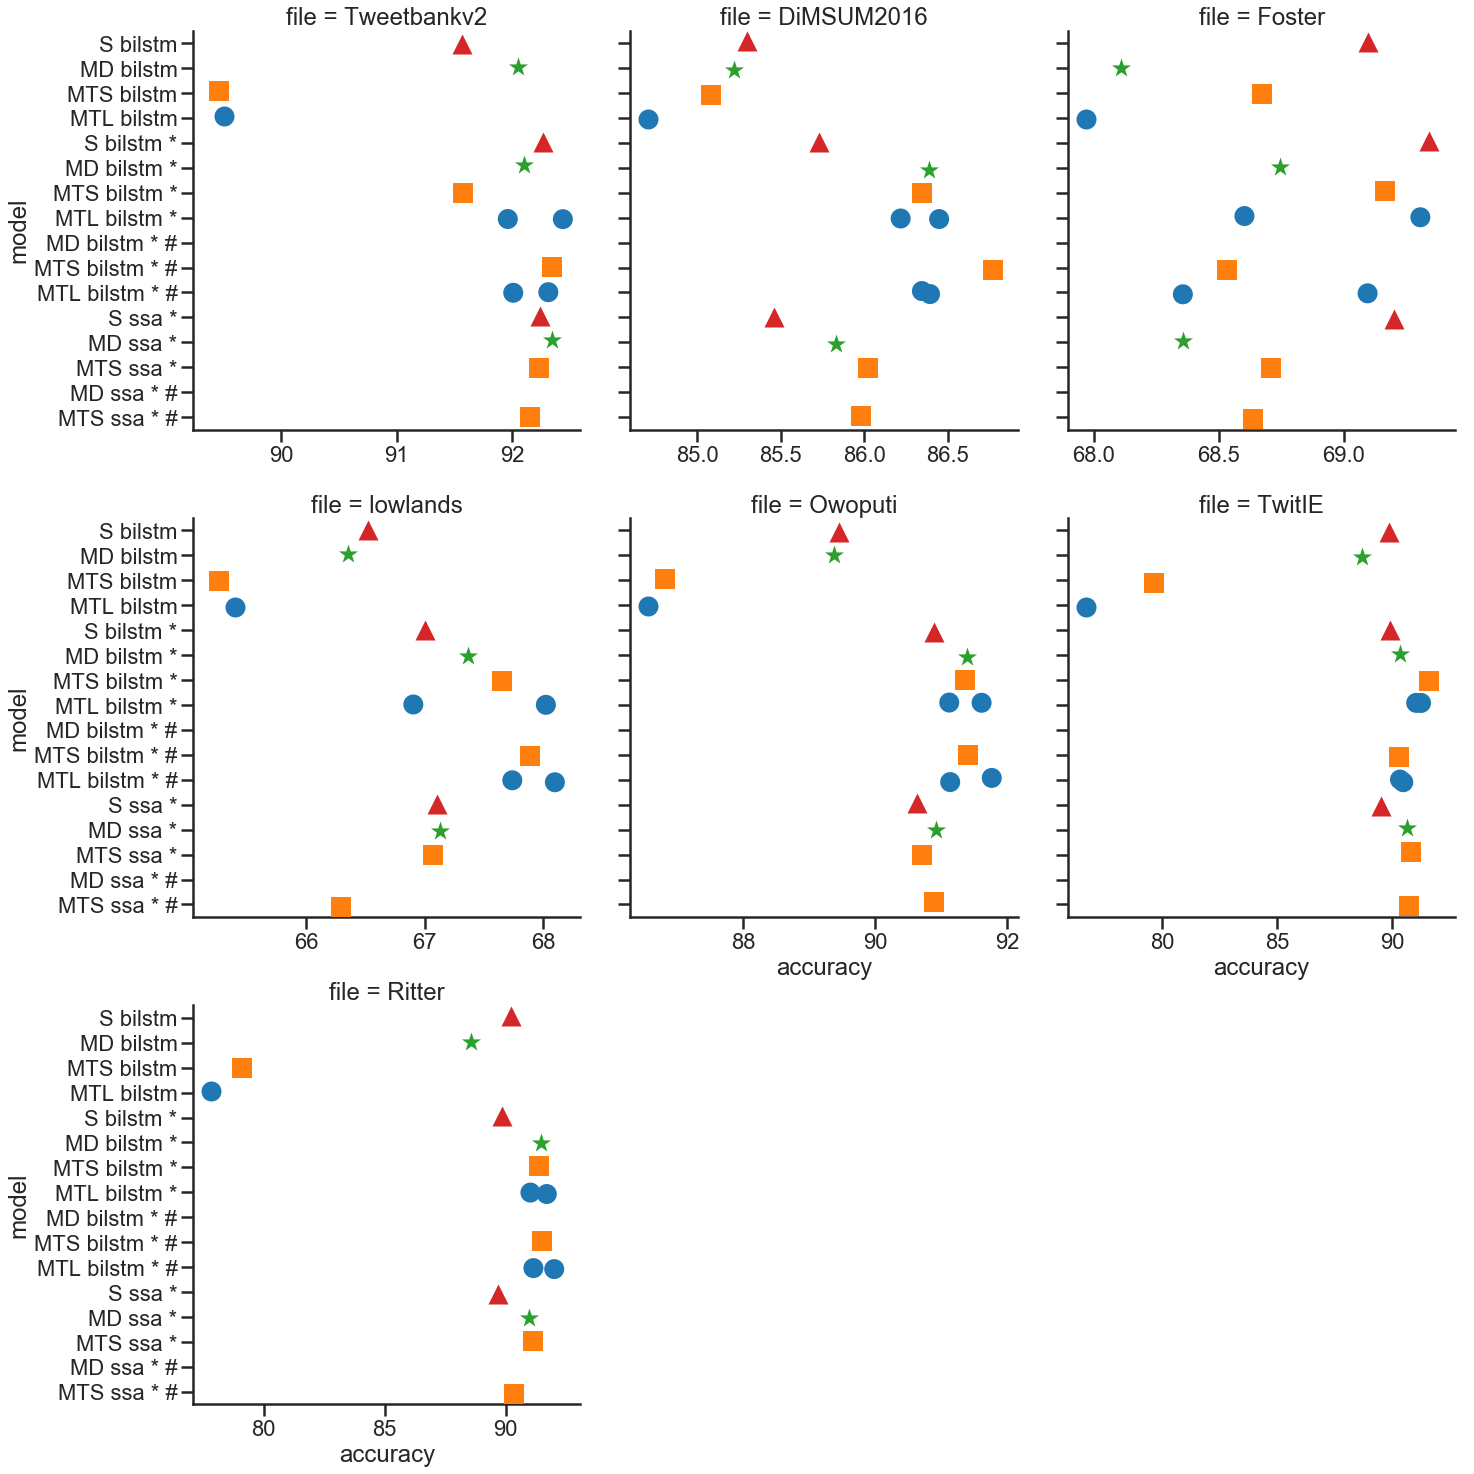

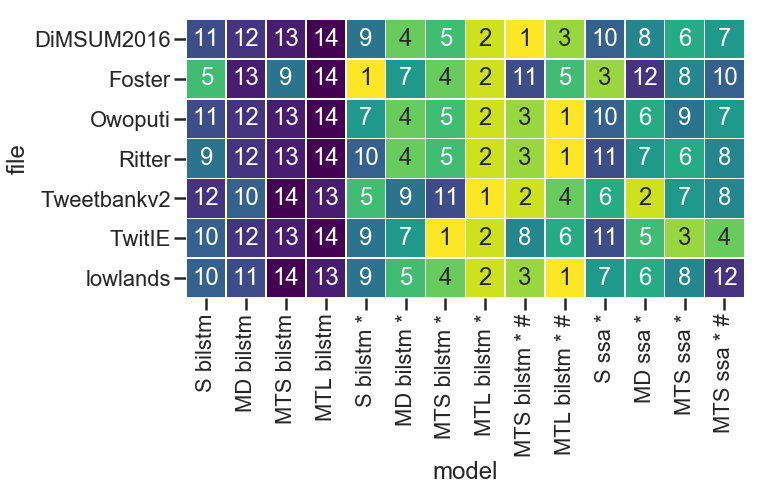

In [11]:
df_t_pos = plot_measures(df, task="pos", measure="accuracy")

file,BROAD,Finin,Hege,MSM2013,MultiModal,Ritter,WNUT2016,WNUT2017,YODIE
model,,,,,,,,,
S bilstm,73.148043,52.527600,87.161430,77.546917,71.980535,65.843621,49.580645,40.375587,58.561297
MD bilstm,71.740139,53.393344,87.977992,77.960301,68.942050,51.754386,43.628014,40.909091,54.025424
MTS bilstm,69.071541,51.125485,87.083812,77.872340,67.473975,53.703704,45.944532,39.199448,21.553090
MTL bilstm,64.663939,51.611407,86.057299,74.786762,64.922441,40.000000,32.506349,38.941399,44.712430
S bilstm *,76.757133,54.197636,88.587258,80.455016,72.830982,71.936759,47.414998,42.529448,52.598753
MD bilstm *,76.350484,55.277369,89.080780,79.986680,73.390302,82.071713,53.161741,45.877734,62.829268
MTS bilstm *,76.845135,55.218216,88.694702,78.527607,72.978265,83.397683,50.220126,49.862411,60.314342
MTL bilstm *,76.590360,56.423054,88.436123,79.739011,71.959858,85.057471,47.457627,45.445642,62.884615
MD bilstm * #,77.401456,55.402380,89.454944,80.317132,73.379283,84.848485,50.731557,48.345485,65.388303


file           BROAD        Finin        Hege        MSM2013         \
                   r      v     r      v    r      v       r      v   
model                                                                 
S bilstm          13  73.15    14  52.53   13  87.16      15  77.55   
MD bilstm         14  71.74    12  53.39    9  87.98      13  77.96   
MTS bilstm        15  69.07    16  51.13   14  87.08      14  77.87   
MTL bilstm        16  64.66    15  51.61   15  86.06      16  74.79   
S bilstm *         3  76.76    10  54.20    5  88.59       1  80.46   
MD bilstm *        6  76.35     4  55.28    2  89.08       3  79.99   
MTS bilstm *       2  76.85     6  55.22    4  88.69      10  78.53   
MTL bilstm *       4  76.59     1  56.42    6  88.44       5  79.74   
MD bilstm * #      1  77.40     3  55.40    1  89.45       2  80.32   
MTS bilstm * #     5  76.40     5  55.24    3  89.07      12  78.05   
MTL bilstm * #     7  75.76     2  56.18   12  87.42       7  79.46   
S ssa *            9  75.11    13  52.58    8  88.22       6  79.55   
MD ssa *           8  75.50    11  53.62    7  88.42       4  79.80   
MTS ssa *         11  74.93     7  55.08   10  87.87       8  79.18   
MD ssa * #        12  74.84     8  54.72   11  87.59       9  78.59   
MTS ssa * #       10  74.96     9  54.53   16  83.64      11  78.43   

file           MultiModal        Ritter        WNUT2016        WNUT2017  \
                        r      v      r      v        r      v        r   
model                                                                     
S bilstm               12  71.98     13  65.84        9  49.58       14   
MD bilstm              14  68.94     15  51.75       15  43.63       13   
MTS bilstm             15  67.47     14  53.70       14  45.94       15   
MTL bilstm             16  64.92     16  40.00       16  32.51       16   
S bilstm *              4  72.83     12  71.94       12  47.41       12   
MD bilstm *             1  73.39      6  82.07        1  53.16        6   
MTS bilstm *            3  72.98      4  83.40        8  50.22        1   
MTL bilstm *           13  71.96      2  85.06       11  47.46        7   
MD bilstm * #           2  73.38      3  84.85        2  50.73        2   
MTS bilstm * #          5  72.81      5  82.89        6  50.43        5   
MTL bilstm * #         10  72.08      1  86.04       10  48.37       11   
S ssa *                 9  72.09      7  80.15       13  46.40       10   
MD ssa *                8  72.40      8  78.88        3  50.68        3   
MTS ssa *               6  72.66     10  76.98        4  50.57        4   
MD ssa * #              7  72.40      9  77.74        5  50.47        8   
MTS ssa * #            11  72.07     11  76.23        7  50.37        9   

file                  YODIE         
                    v     r      v  
model                               
S bilstm        40.38    11  58.56  
MD bilstm       40.91    13  54.03  
MTS bilstm      39.20    16  21.55  
MTL bilstm      38.94    15  44.71  
S bilstm *      42.53    14  52.60  
MD bilstm *     45.88     7  62.83  
MTS bilstm *    49.86    10  60.31  
MTL bilstm *    45.45     6  62.88  
MD bilstm * #   48.35     1  65.39  
MTS bilstm * #  46.56     9  61.74  
MTL bilstm * #  42.87     5  63.01  
S ssa *         43.36    12  55.43  
MD ssa *        48.12     3  63.35  
MTS ssa *       46.83     8  62.36  
MD ssa * #      45.00     2  63.87  
MTS ssa * #     43.60     4  63.08

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{BROAD} & \multicolumn{2}{c}{Finin} & \multicolumn{2}{c}{Hege} & \multicolumn{2}{c}{MSM2013} & \multicolumn{2}{c}{MultiModal} & \multicolumn{2}{c}{Ritter} & \multicolumn{2}{c}{WNUT2016} & \multicolumn{2}{c}{WNUT2017} & \multicolumn{2}{c}{YODIE} \\
{} &     r &      v &     r &      v &    r &      v &       r &      v &          r &      v &      r &      v &        r &      v &        r &      v &     r &      v \\
\textbf{model         } &       &        &       &        &      &        &         &        &            &        &        &        &          &        &          &        &       &        \\
\midrule
\textbf{S bilstm      } &    13 &  73.15 &    14 &  52.53 &   13 &  87.16 &      15 &  77.55 &         12 &  71.98 &     13 &  65.84 &        9 &  49.58 &       14 &  40.38 &    11 &  58.56 \\
\textbf{MD bilstm     } &    14 &  71.74 &    12 &  53.39 &    9 &  87.98 &      13 &  77.96 &         14

,model,score
file,,
BROAD,MD bilstm * #,77.401456
Finin,MTL bilstm *,56.423054
Hege,MD bilstm * #,89.454944
MSM2013,S bilstm *,80.455016
MultiModal,MD bilstm *,73.390302
Ritter,MTL bilstm * #,86.037736
WNUT2016,MD bilstm *,53.161741
WNUT2017,MTS bilstm *,49.862411
YODIE,MD bilstm * #,65.388303


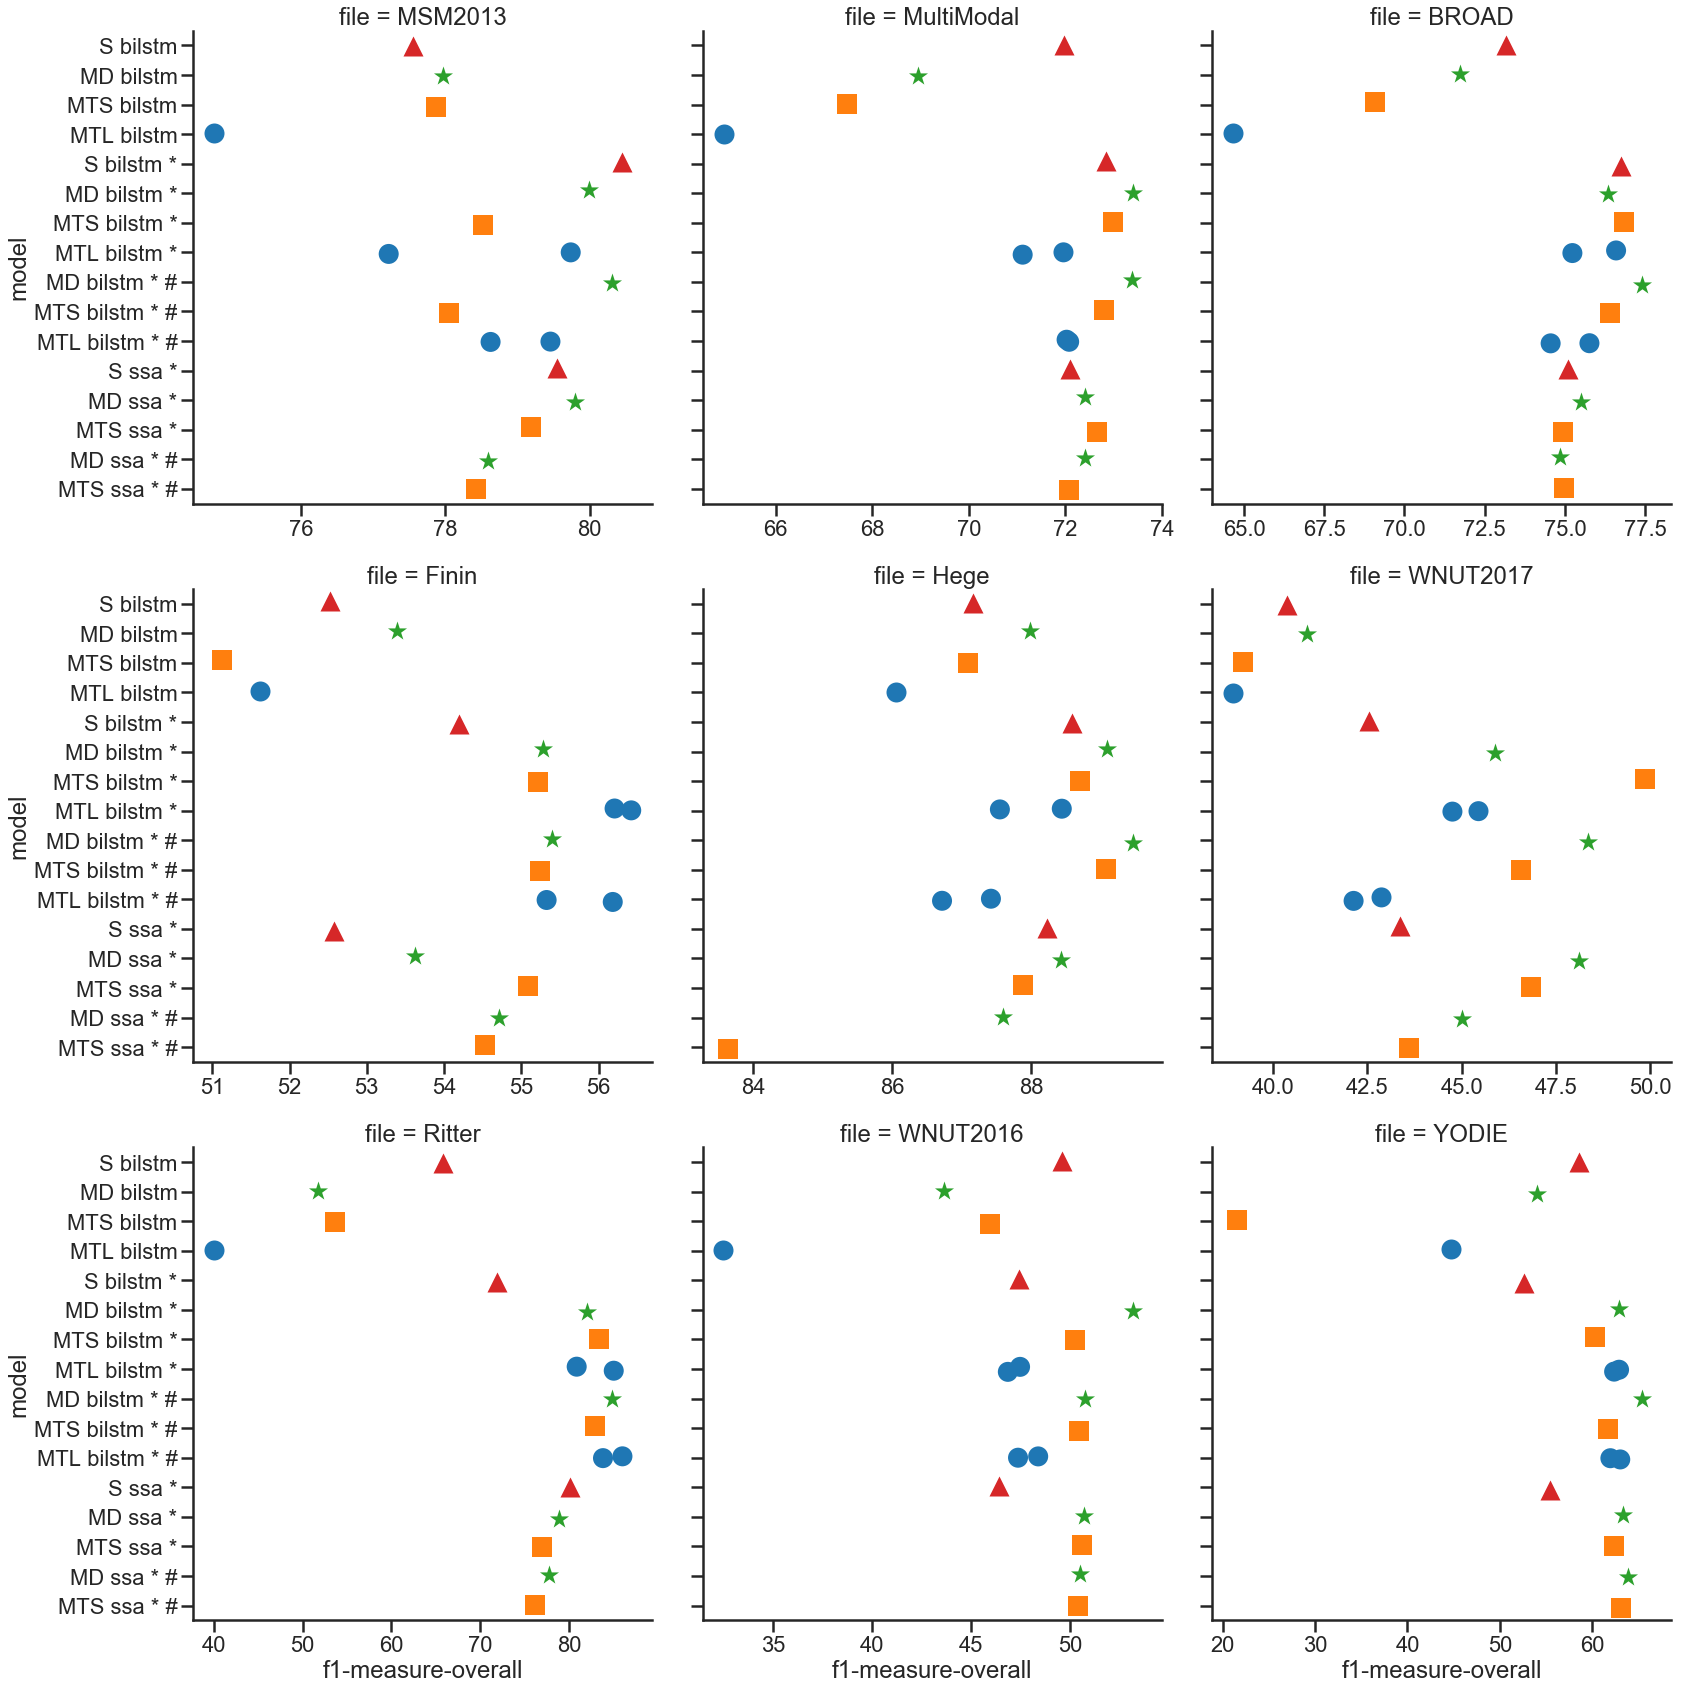

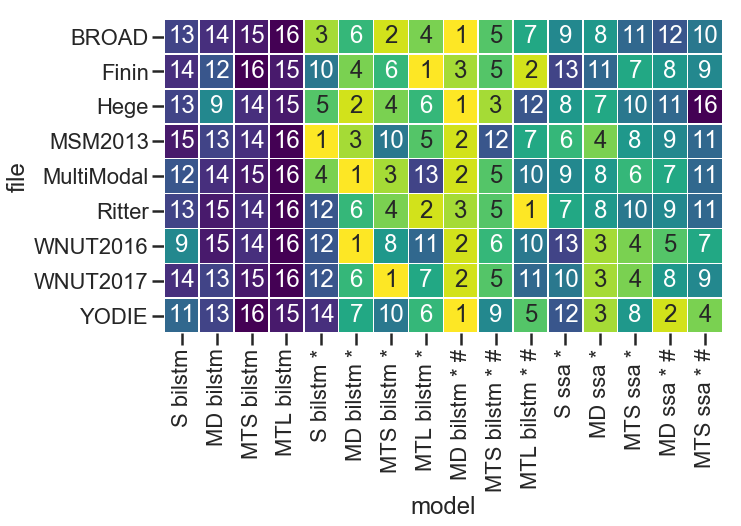

In [12]:
df_t_ner = plot_measures(df, task="ner", measure="f1-measure-overall")

file,Ritter
model,
S bilstm,85.315243
MTS bilstm,78.509120
MTL bilstm,72.727273
S bilstm *,83.537308
MTS bilstm *,87.171315
MTL bilstm *,87.847498
MTS bilstm * #,87.680000
MTL bilstm * #,88.924176
S ssa *,80.700389


file           Ritter       
                    r      v
model                       
S bilstm            5  85.32
MTS bilstm         10  78.51
MTL bilstm         11  72.73
S bilstm *          7  83.54
MTS bilstm *        4  87.17
MTL bilstm *        2  87.85
MTS bilstm * #      3  87.68
MTL bilstm * #      1  88.92
S ssa *             9  80.70
MTS ssa *           6  85.09
MTS ssa * #         8  82.55

\begin{tabular}{lrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Ritter} \\
{} &      r &      v \\
\textbf{model         } &        &        \\
\midrule
\textbf{S bilstm      } &      5 &  85.32 \\
\textbf{MTS bilstm    } &     10 &  78.51 \\
\textbf{MTL bilstm    } &     11 &  72.73 \\
\textbf{S bilstm *    } &      7 &  83.54 \\
\textbf{MTS bilstm *  } &      4 &  87.17 \\
\textbf{MTL bilstm *  } &      2 &  87.85 \\
\textbf{MTS bilstm * \#} &      3 &  87.68 \\
\textbf{MTL bilstm * \#} &      1 &  88.92 \\
\textbf{S ssa *       } &      9 &  80.70 \\
\textbf{MTS ssa *     } &      6 &  85.09 \\
\textbf{MTS ssa * \#   } &      8 &  82.55 \\
\bottomrule
\end{tabular}

Index(['Ritter'], dtype='object', name='file')


,model,score
file,,
Ritter,MTL bilstm * #,88.924176


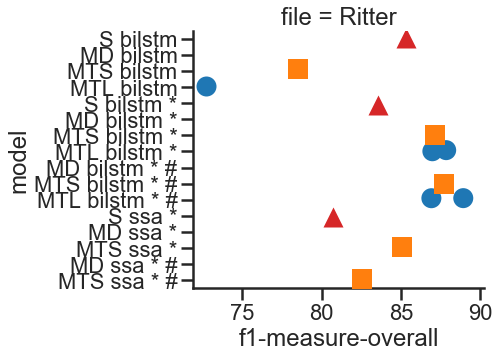

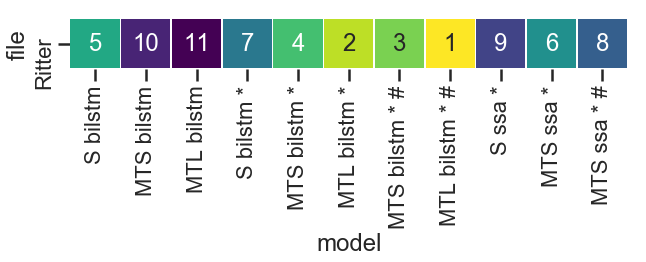

In [13]:
df_t_chunk = plot_measures(df, task="chunk", measure="f1-measure-overall")

file,Johannsen2014,Ritter
model,,
S bilstm,34.328358,56.984786
MTS bilstm,20.194647,33.442088
MTL bilstm,19.963201,26.342711
S bilstm *,32.234763,52.126200
MTS bilstm *,36.380862,54.203093
MTL bilstm *,32.391714,48.200950
MTS bilstm * #,37.380497,53.769179
MTL bilstm * #,31.574117,48.800000
S ssa *,36.280234,58.174655


file           Johannsen2014        Ritter       
                           r      v      r      v
model                                            
S bilstm                   6  34.33      4  56.98
MTS bilstm                10  20.19     10  33.44
MTL bilstm                11  19.96     11  26.34
S bilstm *                 8  32.23      7  52.13
MTS bilstm *               4  36.38      5  54.20
MTL bilstm *               7  32.39      9  48.20
MTS bilstm * #             3  37.38      6  53.77
MTL bilstm * #             9  31.57      8  48.80
S ssa *                    5  36.28      3  58.17
MTS ssa *                  2  40.56      2  58.36
MTS ssa * #                1  42.38      1  59.16

\begin{tabular}{lrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Johannsen2014} & \multicolumn{2}{c}{Ritter} \\
{} &             r &      v &      r &      v \\
\textbf{model         } &               &        &        &        \\
\midrule
\textbf{S bilstm      } &             6 &  34.33 &      4 &  56.98 \\
\textbf{MTS bilstm    } &            10 &  20.19 &     10 &  33.44 \\
\textbf{MTL bilstm    } &            11 &  19.96 &     11 &  26.34 \\
\textbf{S bilstm *    } &             8 &  32.23 &      7 &  52.13 \\
\textbf{MTS bilstm *  } &             4 &  36.38 &      5 &  54.20 \\
\textbf{MTL bilstm *  } &             7 &  32.39 &      9 &  48.20 \\
\textbf{MTS bilstm * \#} &             3 &  37.38 &      6 &  53.77 \\
\textbf{MTL bilstm * \#} &             9 &  31.57 &      8 &  48.80 \\
\textbf{S ssa *       } &             5 &  36.28 &      3 &  58.17 \\
\textbf{MTS ssa *     } &             2 &  40.56 &      2 &  58.36 \\
\textbf{MTS ssa * \#   } &             1 &  42.38 &     

,model,score
file,,
Johannsen2014,MTS ssa * #,42.384106
Ritter,MTS ssa * #,59.164420


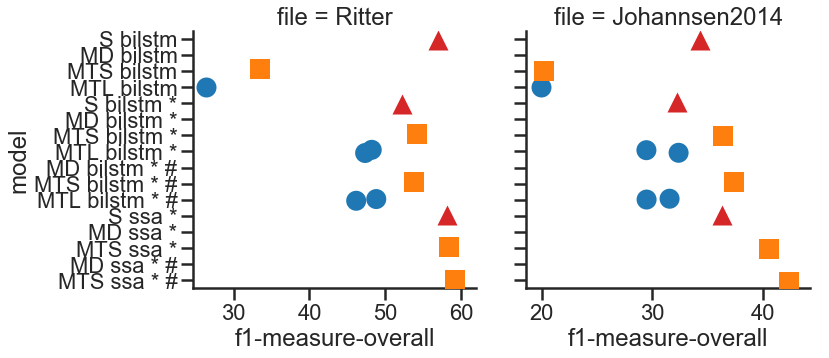

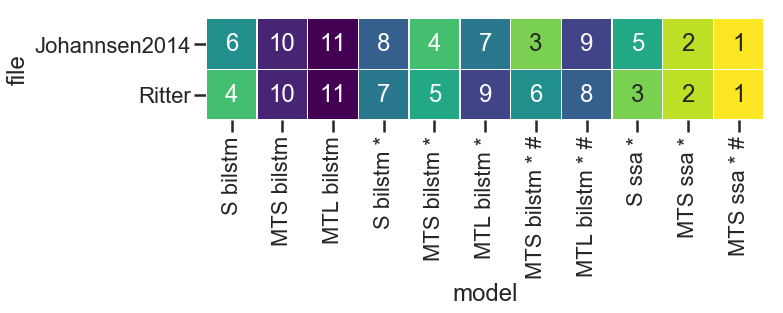

In [14]:
df_t_ccg = plot_measures(df, task="ccg", measure="f1-measure-overall")

In [15]:
df_ner_neel = df[df.file == "NER_NEEL2016"][["model", "precision-overall", "recall-overall", "f1-measure-overall"]].assign(
    model=lambda x: pd.Categorical(x["model"], categories=TRUE_MODEL_ORDER, ordered=True)
).set_index("model").sort_index()*100.
with pd.option_context("precision", 2):
    display(df_ner_neel)
    print(df_ner_neel.to_latex(bold_rows=True, multicolumn_format='c'))

,precision-overall,recall-overall,f1-measure-overall
model,,,
S bilstm,3.09,20.32,5.36
MD bilstm,4.30,17.12,6.88
MTS bilstm,3.02,3.77,3.35
MTL bilstm,3.00,6.39,4.08
S bilstm *,4.32,24.43,7.35
MD bilstm *,4.06,21.58,6.84
MTS bilstm *,3.26,22.26,5.69
MTL bilstm *,2.50,18.15,4.39
MTL bilstm *,3.47,19.86,5.91


\begin{tabular}{lrrr}
\toprule
{} &  precision-overall &  recall-overall &  f1-measure-overall \\
\textbf{model       } &                    &                 &                     \\
\midrule
\textbf{S bilstm    } &               3.09 &           20.32 &                5.36 \\
\textbf{MD bilstm   } &               4.30 &           17.12 &                6.88 \\
\textbf{MTS bilstm  } &               3.02 &            3.77 &                3.35 \\
\textbf{MTL bilstm  } &               3.00 &            6.39 &                4.08 \\
\textbf{S bilstm *  } &               4.32 &           24.43 &                7.35 \\
\textbf{MD bilstm * } &               4.06 &           21.58 &                6.84 \\
\textbf{MTS bilstm *} &               3.26 &           22.26 &                5.69 \\
\textbf{MTL bilstm *} &               2.50 &           18.15 &                4.39 \\
\textbf{MTL bilstm *} &               3.47 &           19.86 &                5.91 \\
\textbf{S ssa *     } &          

In [16]:
df_t_all_ranks = pd.concat({
    "pos": df_t_pos.xs("r", level=1, axis=1),
    "ner": df_t_ner.xs("r", level=1, axis=1),
    "chunk": df_t_chunk.xs("r", level=1, axis=1),
    "supersense": df_t_ccg.xs("r", level=1, axis=1),
}, axis=1, sort=False).astype(float)

df_t_all_eval_scores = pd.concat({
    "pos": df_t_pos.xs("v", level=1, axis=1),
    "ner": df_t_ner.xs("v", level=1, axis=1),
    "chunk": df_t_chunk.xs("v", level=1, axis=1),
    "supersense": df_t_ccg.xs("v", level=1, axis=1),
}, axis=1, sort=False).astype(float)

df_t_all_ranks

chunk   ner                                                 \
file           Ritter BROAD Finin  Hege MSM2013 MultiModal Ritter WNUT2016   
S bilstm          5.0  13.0  14.0  13.0    15.0       12.0   13.0      9.0   
MTS bilstm       10.0  15.0  16.0  14.0    14.0       15.0   14.0     14.0   
MTL bilstm       11.0  16.0  15.0  15.0    16.0       16.0   16.0     16.0   
S bilstm *        7.0   3.0  10.0   5.0     1.0        4.0   12.0     12.0   
MTS bilstm *      4.0   2.0   6.0   4.0    10.0        3.0    4.0      8.0   
MTL bilstm *      2.0   4.0   1.0   6.0     5.0       13.0    2.0     11.0   
MTS bilstm * #    3.0   5.0   5.0   3.0    12.0        5.0    5.0      6.0   
MTL bilstm * #    1.0   7.0   2.0  12.0     7.0       10.0    1.0     10.0   
S ssa *           9.0   9.0  13.0   8.0     6.0        9.0    7.0     13.0   
MTS ssa *         6.0  11.0   7.0  10.0     8.0        6.0   10.0      4.0   
MTS ssa * #       8.0  10.0   9.0  16.0    11.0       11.0   11.0      7.0   
MD bilstm         NaN  14.0  12.0   9.0    13.0       14.0   15.0     15.0   
MD bilstm *       NaN   6.0   4.0   2.0     3.0        1.0    6.0      1.0   
MD bilstm * #     NaN   1.0   3.0   1.0     2.0        2.0    3.0      2.0   
MD ssa *          NaN   8.0  11.0   7.0     4.0        8.0    8.0      3.0   
MD ssa * #        NaN  12.0   8.0  11.0     9.0        7.0    9.0      5.0   

                                     pos                                    \
file           WNUT2017 YODIE DiMSUM2016 Foster Owoputi Ritter Tweetbankv2   
S bilstm           14.0  11.0       11.0    5.0    11.0    9.0        12.0   
MTS bilstm         15.0  16.0       13.0    9.0    13.0   13.0        14.0   
MTL bilstm         16.0  15.0       14.0   14.0    14.0   14.0        13.0   
S bilstm *         12.0  14.0        9.0    1.0     7.0   10.0         5.0   
MTS bilstm *        1.0  10.0        5.0    4.0     5.0    5.0        11.0   
MTL bilstm *        7.0   6.0        2.0    2.0     2.0    2.0         1.0   
MTS bilstm * #      5.0   9.0        1.0   11.0     3.0    3.0         2.0   
MTL bilstm * #     11.0   5.0        3.0    5.0     1.0    1.0         4.0   
S ssa *            10.0  12.0       10.0    3.0    10.0   11.0         6.0   
MTS ssa *           4.0   8.0        6.0    8.0     9.0    6.0         7.0   
MTS ssa * #         9.0   4.0        7.0   10.0     7.0    8.0         8.0   
MD bilstm          13.0  13.0       12.0   13.0    12.0   12.0        10.0   
MD bilstm *         6.0   7.0        4.0    7.0     4.0    4.0         9.0   
MD bilstm * #       2.0   1.0        NaN    NaN     NaN    NaN         NaN   
MD ssa *            3.0   3.0        8.0   12.0     6.0    7.0         2.0   
MD ssa * #          8.0   2.0        NaN    NaN     NaN    NaN         NaN   

                                  supersense         
file           TwitIE lowlands Johannsen2014 Ritter  
S bilstm         10.0     10.0           6.0    4.0  
MTS bilstm       13.0     14.0          10.0   10.0  
MTL bilstm       14.0     13.0          11.0   11.0  
S bilstm *        9.0      9.0           8.0    7.0  
MTS bilstm *      1.0      4.0           4.0    5.0  
MTL bilstm *      2.0      2.0           7.0    9.0  
MTS bilstm * #    8.0      3.0           3.0    6.0  
MTL bilstm * #    6.0      1.0           9.0    8.0  
S ssa *          11.0      7.0           5.0    3.0  
MTS ssa *         3.0      8.0           2.0    2.0  
MTS ssa * #       4.0     12.0           1.0    1.0  
MD bilstm        12.0     11.0           NaN    NaN  
MD bilstm *       7.0      5.0           NaN    NaN  
MD bilstm * #     NaN      NaN           NaN    NaN  
MD ssa *          5.0      6.0           NaN    NaN  
MD ssa * #        NaN      NaN           NaN    NaN

In [17]:
with pd.option_context("precision", 2):
    display(df_t_all_eval_scores)
    print(df_t_all_eval_scores.to_latex(bold_rows=True, multicolumn_format='c', na_rep="-"))

chunk    ner                                                   \
file           Ritter  BROAD  Finin   Hege MSM2013 MultiModal Ritter WNUT2016   
S bilstm        85.32  73.15  52.53  87.16   77.55      71.98  65.84    49.58   
MTS bilstm      78.51  69.07  51.13  87.08   77.87      67.47  53.70    45.94   
MTL bilstm      72.73  64.66  51.61  86.06   74.79      64.92  40.00    32.51   
S bilstm *      83.54  76.76  54.20  88.59   80.46      72.83  71.94    47.41   
MTS bilstm *    87.17  76.85  55.22  88.69   78.53      72.98  83.40    50.22   
MTL bilstm *    87.85  76.59  56.42  88.44   79.74      71.96  85.06    47.46   
MTS bilstm * #  87.68  76.40  55.24  89.07   78.05      72.81  82.89    50.43   
MTL bilstm * #  88.92  75.76  56.18  87.42   79.46      72.08  86.04    48.37   
S ssa *         80.70  75.11  52.58  88.22   79.55      72.09  80.15    46.40   
MTS ssa *       85.09  74.93  55.08  87.87   79.18      72.66  76.98    50.57   
MTS ssa * #     82.55  74.96  54.53  83.64   78.43      72.07  76.23    50.37   
MD bilstm         NaN  71.74  53.39  87.98   77.96      68.94  51.75    43.63   
MD bilstm *       NaN  76.35  55.28  89.08   79.99      73.39  82.07    53.16   
MD bilstm * #     NaN  77.40  55.40  89.45   80.32      73.38  84.85    50.73   
MD ssa *          NaN  75.50  53.62  88.42   79.80      72.40  78.88    50.68   
MD ssa * #        NaN  74.84  54.72  87.59   78.59      72.40  77.74    50.47   

                                      pos                                    \
file           WNUT2017  YODIE DiMSUM2016 Foster Owoputi Ritter Tweetbankv2   
S bilstm          40.38  58.56      85.30  69.10   89.46  90.23       91.57   
MTS bilstm        39.20  21.55      85.08  68.67   86.81  79.10       89.46   
MTL bilstm        38.94  44.71      84.71  67.97   86.56  77.81       89.50   
S bilstm *        42.53  52.60      85.73  69.34   90.88  89.86       92.27   
MTS bilstm *      49.86  60.31      86.35  69.17   91.36  91.40       91.57   
MTL bilstm *      45.45  62.88      86.45  69.31   91.61  91.70       92.44   
MTS bilstm * #    46.56  61.74      86.77  68.53   91.40  91.52       92.34   
MTL bilstm * #    42.87  63.01      86.39  69.10   91.76  92.01       92.31   
S ssa *           43.36  55.43      85.46  69.20   90.63  89.67       92.24   
MTS ssa *         46.83  62.36      86.02  68.71   90.72  91.15       92.23   
MTS ssa * #       43.60  63.08      85.98  68.64   90.88  90.35       92.16   
MD bilstm         40.91  54.03      85.22  68.11   89.37  88.57       92.05   
MD bilstm *       45.88  62.83      86.39  68.74   91.39  91.46       92.10   
MD bilstm * #     48.35  65.39        NaN    NaN     NaN    NaN         NaN   
MD ssa *          48.12  63.35      85.83  68.36   90.93  90.96       92.34   
MD ssa * #        45.00  63.87        NaN    NaN     NaN    NaN         NaN   

                                  supersense         
file           TwitIE lowlands Johannsen2014 Ritter  
S bilstm        89.86    66.52         34.33  56.98  
MTS bilstm      79.66    65.27         20.19  33.44  
MTL bilstm      76.66    65.40         19.96  26.34  
S bilstm *      89.90    67.01         32.23  52.13  
MTS bilstm *    91.62    67.65         36.38  54.20  
MTL bilstm *    91.27    68.02         32.39  48.20  
MTS bilstm * #  90.32    67.89         37.38  53.77  
MTL bilstm * #  90.50    68.10         31.57  48.80  
S ssa *         89.55    67.10         36.28  58.17  
MTS ssa *       90.85    67.07         40.56  58.36  
MTS ssa * #     90.74    66.30         42.38  59.16  
MD bilstm       88.70    66.35           NaN    NaN  
MD bilstm *     90.36    67.36           NaN    NaN  
MD bilstm * #     NaN      NaN           NaN    NaN  
MD ssa *        90.67    67.13           NaN    NaN  
MD ssa * #        NaN      NaN           NaN    NaN

\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  chunk & \multicolumn{9}{c}{ner} & \multicolumn{7}{c}{pos} & \multicolumn{2}{c}{supersense} \\
\textbf{file} & Ritter &  BROAD &  Finin &   Hege & MSM2013 & MultiModal & Ritter & WNUT2016 & WNUT2017 &  YODIE & DiMSUM2016 & Foster & Owoputi & Ritter & Tweetbankv2 & TwitIE & lowlands & Johannsen2014 & Ritter \\
\midrule
\textbf{S bilstm      } &  85.32 &  73.15 &  52.53 &  87.16 &   77.55 &      71.98 &  65.84 &    49.58 &    40.38 &  58.56 &      85.30 &  69.10 &   89.46 &  90.23 &       91.57 &  89.86 &    66.52 &         34.33 &  56.98 \\
\textbf{MTS bilstm    } &  78.51 &  69.07 &  51.13 &  87.08 &   77.87 &      67.47 &  53.70 &    45.94 &    39.20 &  21.55 &      85.08 &  68.67 &   86.81 &  79.10 &       89.46 &  79.66 &    65.27 &         20.19 &  33.44 \\
\textbf{MTL bilstm    } &  72.73 &  64.66 &  51.61 &  86.06 &   74.79 &      64.92 &  40.00 &    32.51 &    38.94 &  44.71 &      84.71 &  67.97 &   86.56 &  77.81 &       89.5

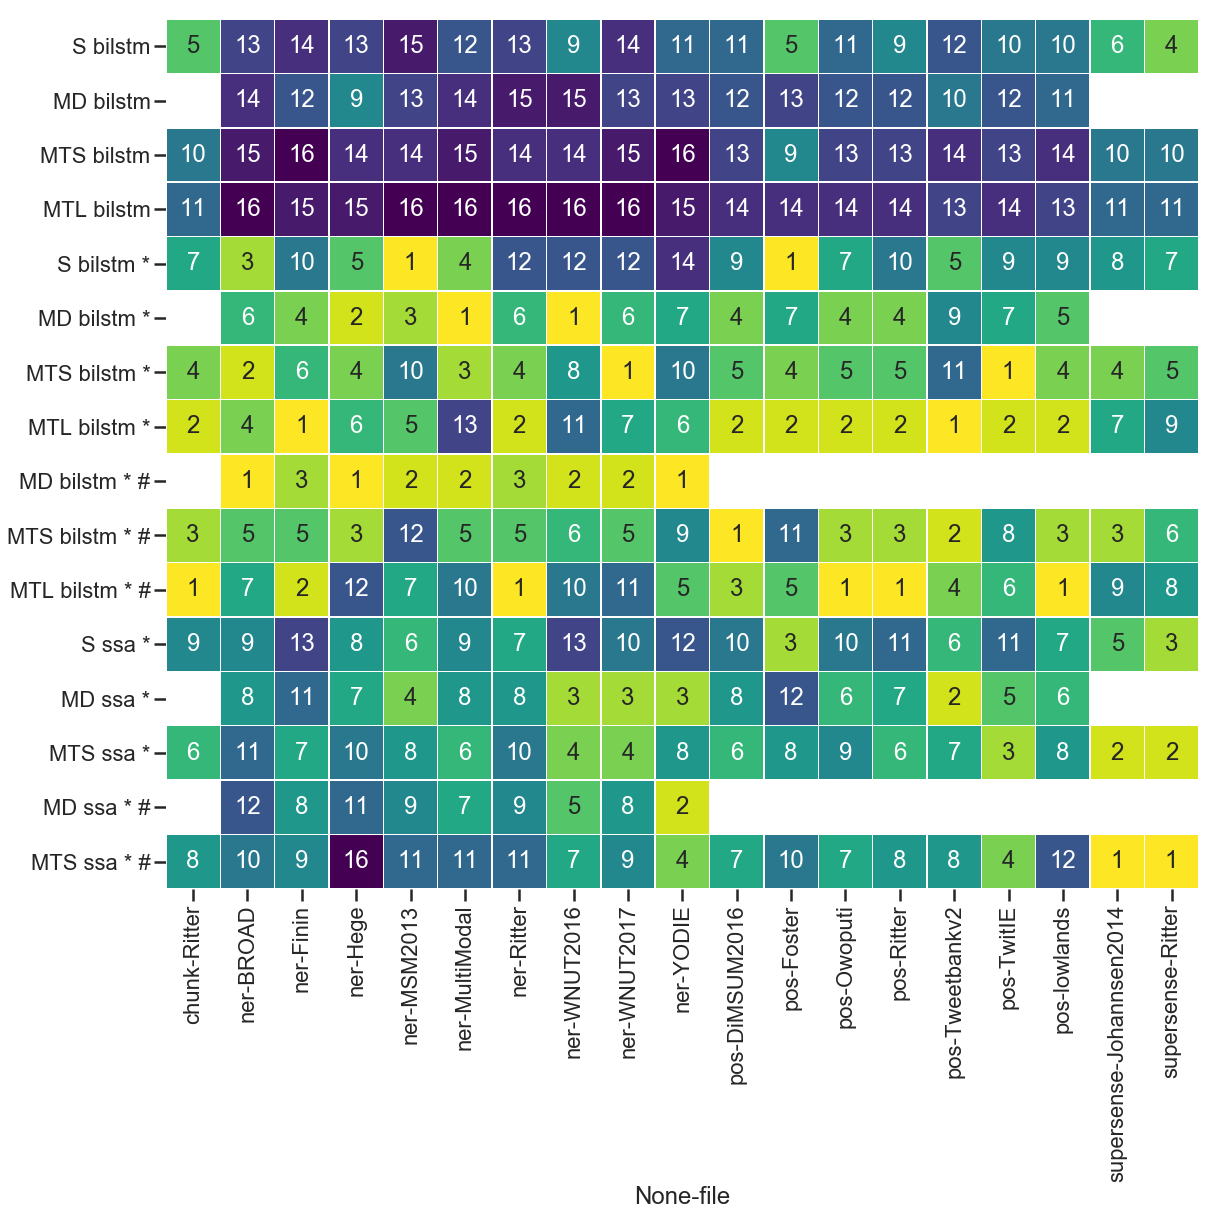

In [18]:
fig = plt.figure(
    figsize=(1*df_t_all_ranks.shape[1], 1*df_t_all_ranks.shape[0])
)

std_eval_scores = (df_t_all_eval_scores - df_t_all_eval_scores.max(axis=0)).divide(df_t_all_eval_scores.std(axis=0))

sns.heatmap(
    #df_t_all_ranks.reindex(std_eval_scores.mean(axis=1).sort_values(ascending=False).index.values, axis=0), 
    df_t_all_ranks.reindex(TRUE_MODEL_ORDER),
    cmap="viridis_r", linewidths=.5, annot=True, fmt=".0f",
    square=True,
    cbar=False
)